# Exploration pour la prédiction des jours Tempo

### Rappel des règles données par RTE pour le placement des jours Tempo: 
- Une année « Tempo » s’étend du 1er septembre d’une année au 31 août de l’année suivante
- Une année Tempo comprend 22 jours rouges et 43 jours blancs
- les jours rouges sont tirés entre le 1er novembre et le 31 mars,
- les jours rouges ne peuvent être tirés le weekend,
- un maximum de 5 jours rouges consécutifs peut être tiré,
- les jours blancs peuvent être tirés toute l’année, sauf le dimanche. 

Source : [Méthode de choix des jours Tempo - Fiche explicative de l’algorithme utilisé par RTE](https://www.services-rte.com/files/live/sites/services-rte/files/pdf/20160106_Methode_de_choix_des_jours_Tempo.pdf)

### Hypothèse / affirmation :  
La production d'éolien et de solaire varie mais est la première brique du mix électrique français. S'ajoute à cette première brique la production du nucléaire, plus grosse base nationale, peu pilotable sur les fluctuations rapides du réseau. Puis viennent charbon et gaz naturel, ce dernier étant le plus pratique pour gérer les fluctuations. 

### Notes :
- Ajouter trois colonnes 'stock_j_blanc', 'stock_j_bleu', 'stock_j_rouge' qui comptent le nombre de jours en stock à J0. Il faut donc prévoir une remise à zéro chaque année.  
=> On pourrait penser que deux colonnes sont suffisantes, mais je pense que le stock de jours bleus peut aussi permettre au modèle de se placer sur le nombre de jours restants sur "l'année Tempo"  
=> Reset les jours chaque année le 1er septembre  <span style="color:green">**Fait**</span>  
- Comment gérer les données manquantes ? On a les données de vent & flux solaire seulement depuis Février 2022.  
=> On peut filtrer sur ces dates là à priori car RTE calcul sur un an glissant à chaque fois <span style="color:green">**Fait**</span>  
- Comment faire comprendre au modèle qu'il ne peut pas prédire un jour rouge dans certain cas ?
=> Ajouter un booléen pour signifier si le jour peut être rouge ou non ?
=> Est-il possible de donner le choix uniquement entre jours blancs et jour bleus les jours quand on est en dehors des conditions pour les jours rouges ?
=> Ou alors encore plus simple : si un jour rouge est prédit, mais les conditions ne sont pas remplies = jour blanc (si stock restant), RTE bosse de cette manière. <span style="color:red">**A faire**</span>  
- Quelles colonnes garder pour le modèle ?
=> Les stocks de jour, la production à J-1, la consommation à J+1, la production ENR (ou flux solaire / vent) à J+1 <span style="color:red">**A faire**</span>  


In [39]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 400)

import os
from calendar import isleap


## Read data

In [2]:
in_relative_path = "../../../data/gold/"
in_absolute_path = os.path.abspath(os.path.join(os.getcwd(), in_relative_path))

data = pd.read_csv(f"{in_absolute_path}/rte_daily_2014_2024.csv")
data["Date"] = pd.to_datetime(data["Date"])


# Feature Engineering
### Ajout des colonnes de stocks restants des jours Tempo

In [3]:
stock_jours_annuels = {
    "rouge": 22,
    "blanc": 43,
    "bleu": 300
}
stock_jours_annuels_b = {
    "rouge": 22,
    "blanc": 43,
    "bleu": 301
}

def get_base_stock(year:int) -> dict:
    """
    Vérifie si l'année est bissextiles ou non
    Renvoie le stock initial de jour tempo.

    :param year: _description_
    :return: _description_
    """
    if isleap(year):
        return stock_jours_annuels_b.copy()
    else:
        return stock_jours_annuels.copy()
    
def update_stock(previous_tempo:str, stock_actuel:dict) -> dict:
    if previous_tempo:
        if previous_tempo == "ROUGE":
            stock_actuel["rouge"] -= 1
        elif previous_tempo == "BLANC":
            stock_actuel["blanc"] -= 1
        elif previous_tempo == "BLEU":
            stock_actuel["bleu"] -= 1
        return stock_actuel
    else:
        return None
    
def check_stock_empty(stock_actuel:dict, year:int):
    """
    Cette fonction permet de vérifier si les stocks sont bien calculés :
    Tout les stocks doivent à 0, si ce n'est pas le cas c'est que RTE
    n'a pas utilisé tout les jours en stock, l'écart devrait alors se 
    répercuter négativement sur les jours bleus (la somme du dictionnaire doit être de 0 forcément)

    :param stock_actuel: _description_
    :param year: _description_
    """
    if stock_actuel:
        if stock_actuel["rouge"] == stock_actuel["bleu"] == stock_actuel["blanc"] == 0:
            pass
        else:
            print(f"Les stocks de jours n'était pas à 0 le 1er septembre {year} ! :(")
            print(f"Voici l'état du stock : {stock_actuel}")
            if stock_actuel["rouge"] + stock_actuel["bleu"] + stock_actuel["blanc"] != 0:
                raise ValueError("La somme des stocks ne fait pas 0 à la fin de l'année.")


def get_cumulative_stock(data):
    """
    On calcule les stocks restants pour chaque jour tempo à une date X.

    Les valeurs représentent la situation à J-1 car la prédiction
    pour une date D se fait avec le stocks restants à J-1.

    Ex : 
    Une row avec 
        - stock_j_rouge = 0
        - stock_j_blanc = 1
        - stock_j_bleu = 14
        - type_tempo = "BLANC"
    => Au moment de prédire le jour "BLANC", je n'avais plus de jour rouge
    mais il me restait un dernier jour blanc en stock

    :param data: _description_
    :return: _description_
    """
    stock_rouge, stock_bleu, stock_blanc = [], [], []
    previous_tempo = stock_actuel = None
    for i, row in data.iterrows():
        # Remise à zéro les 1er Septembre
        # sinon on update le stock en fonction du type tempo de la veille 
        if row["Date"].month == 9 and row["Date"].day == 1:
            update_stock(previous_tempo, stock_actuel)
            check_stock_empty(stock_actuel, row["Date"].year)
            stock_actuel = get_base_stock(row["Date"].year + 1)
        else:
            update_stock(previous_tempo, stock_actuel)
        
        stock_rouge.append(stock_actuel["rouge"])
        stock_blanc.append(stock_actuel["blanc"])
        stock_bleu.append(stock_actuel["bleu"])

        # On enregistre le type tempo
        previous_tempo = row["type_tempo"]
    
    data["stock_j_rouge"] = stock_rouge
    data["stock_j_blanc"] = stock_blanc
    data["stock_j_bleu"] = stock_bleu
    return data

data = get_cumulative_stock(data)

Les stocks de jours n'était pas à 0 le 1er septembre 2020 ! :(
Voici l'état du stock : {'rouge': 4, 'blanc': -4, 'bleu': 0}
Les stocks de jours n'était pas à 0 le 1er septembre 2022 ! :(
Voici l'état du stock : {'rouge': 0, 'blanc': 1, 'bleu': -1}


# Filtre sur les dernières données
### On garde uniquement les données avec des valeurs de vent & flux solaire

In [4]:
data = data[data["Date"] >= "2022-02-01"].reset_index(drop=True)

# Modèles
### 1.  Nucléaire, flux solaire et vent
- Consommation de J
- Production nucléaire de J-1
- Prévision "sun" de J
- Prévision "wind" de J 

In [13]:
def modele_a_transform(data:pd.DataFrame):
    data['Nucléaire_J-1'] = data['Nucléaire'].shift(1)

    columns_to_keep = [
        "Date",
        "Consommation",
        "Nucléaire",
        "Nucléaire_J-1",
        "sun",
        "wind",
        "stock_j_rouge",
        "stock_j_blanc",
        "stock_j_bleu",
        "type_tempo",
    ]
    data = data[columns_to_keep]
    return data

data_a = modele_a_transform(data)
data_a



,Date,Consommation,Nucléaire,Nucléaire_J-1,sun,wind,stock_j_rouge,stock_j_blanc,stock_j_bleu,type_tempo
0,2022-02-01,860492.500,571452.750,NaN,3.901272e+06,4.906875,0,22,190,BLEU
1,2022-02-02,805681.500,573210.000,571452.750,4.494408e+06,3.661905,0,22,189,BLANC
2,2022-02-03,809729.000,578999.250,573210.000,4.781211e+06,2.776255,0,21,189,BLANC
3,2022-02-04,796406.000,575861.750,578999.250,4.245190e+06,3.987258,0,20,189,BLEU
4,2022-02-05,743808.500,538712.500,575861.750,7.963900e+06,3.375999,0,20,188,BLEU
...,...,...,...,...,...,...,...,...,...,...
794,2024-04-05,556538.000,407607.375,433068.125,1.423090e+07,4.879554,0,8,141,BLEU
795,2024-04-06,485519.875,324737.250,407607.375,1.757204e+07,5.793304,0,8,140,BLEU
796,2024-04-07,464582.375,308369.250,324737.250,1.166932e+07,3.579645,0,8,139,BLEU
797,2024-04-08,290497.750,243594.250,308369.250,1.391853e+07,4.507709,0,8,138,BLEU


Précision du modèle: 91.67%


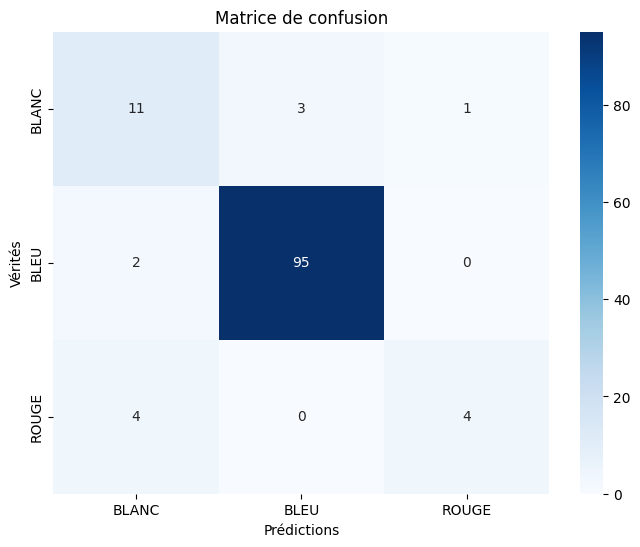

Rapport de classification :
               precision    recall  f1-score   support

       BLANC       0.65      0.73      0.69        15
        BLEU       0.97      0.98      0.97        97
       ROUGE       0.80      0.50      0.62         8

    accuracy                           0.92       120
   macro avg       0.81      0.74      0.76       120
weighted avg       0.92      0.92      0.91       120



In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que df soit votre DataFrame
# df = pd.read_csv('votre_fichier.csv')

df = data_a.copy()

# Encodage de la variable cible
label_encoder = LabelEncoder()
df['type_tempo'] = label_encoder.fit_transform(df['type_tempo'])

# Séparation des features et de la cible
X = df.drop(columns=['Date', 'type_tempo'])
y = df['type_tempo']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Préparation des datasets LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Définition des paramètres du modèle
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Entraînement du modèle
bst = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

# Prédictions sur les données de test
y_pred = bst.predict(X_test)
y_pred_max = np.argmax(y_pred, axis=1)

# Calcul de la précision
accuracy = accuracy_score(y_test, y_pred_max)
print(f'Précision du modèle: {accuracy * 100:.2f}%')

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_max)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de confusion')
plt.show()

# Rapport de classification
class_report = classification_report(y_test, y_pred_max, target_names=label_encoder.classes_)
print('Rapport de classification :\n', class_report)

In [12]:
data_a.dtypes

Date             datetime64[ns]
Consommation            float64
Nucléaire               float64
Nucléaire_J-1           float64
sun                     float64
wind                    float64
type_tempo               object
dtype: object